<a href="https://colab.research.google.com/github/kfir1g/Engineering_final_project/blob/master/Autoencoder_Latent_Space.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading Tensorflow on colab

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

## Imports and Constants
Change the following constants as you see fit

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, InputLayer, Reshape, Conv2DTranspose
from tensorflow.keras import Model
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold

TRAIN_BUF = 60000
BATCH_SIZE = 1000
TEST_BUF = 10000
EPOCHES = 20
NOISE_RATIO = 0.0    # noise should be in the range [0, 1]
LEARNING_RATE = 1e-3
VISUALIZE_IMAGE_EXAMPLE = True
VISUALIZE_LATENT_SPACE = True
SHOW_PREDICTION_EXAMPLE = True

## Defining the AutoEncoder

In [0]:
class Encoder (Model):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = Conv2D(32, 3, strides=(2, 2), activation='relu')
        self.conv2 = Conv2D(64, 3, strides=(2, 2), activation='relu')
        self.flatten = Flatten()
        self.dense1 = Dense(512, activation='relu')
        self.dense2 = Dense(10, activation='relu')

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        return self.dense2(x)


class Decoder(Model):
    def __init__(self):
        super(Decoder, self).__init__()
        self.dense1 = Dense(512, activation='relu')
        self.dense2 = Dense(7 * 7 * 64, activation='relu')
        self.reshape = Reshape(target_shape=(7, 7, 64))
        self.transConv1 = Conv2DTranspose(filters=32, kernel_size=3, strides=(2, 2), activation='relu', padding='same')
        self.transConv2 = Conv2DTranspose(filters=1, kernel_size=3, strides=(2, 2), activation='sigmoid', padding='same')

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.reshape(x)
        x = self.transConv1(x)
        return self.transConv2(x)


class AutoEncoder(Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def call(self, x):
        output = []
        x = self.encoder(x)
        output.append(x)
        x = self.decoder(x)
        output.append(x)
        return output

## Loading Data
Loading mnist data, and normalizing it

In [0]:
def load_and_prep_data(noise_ratio=0.0):
    """Loads data from Mnist and normalize it to the range [0, 1]"""
    (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
    train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
    test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

    # Normalization of the data
    train_images = (train_images - train_images.min()) / (train_images.max() - train_images.min())
    test_images = (test_images - test_images.min()) / (test_images.max() - test_images.min()) 

    # Add noise to the image
    if noise_ratio:
        train_images = train_images + noise_ratio * np.random.normal(loc=0, scale=1.0, size=train_images.shape)
        train_images = np.clip(train_images, 0.0, 1.0)
        test_images = test_images + noise_ratio * np.random.normal(loc=0, scale=1.0, size=test_images.shape)
        test_images = np.clip(test_images, 0.0, 1.0)
        train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
        test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
    test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).shuffle(TEST_BUF).batch(BATCH_SIZE)
    return train_dataset, test_dataset

## Method definition
The following methods define the training process

In [0]:
def reset_states():
    """This function reset the accuracy and the loss"""
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()


def loss_l2(images, predictions):
    """loss object"""
    return tf.reduce_mean(tf.square(images - predictions))


@tf.function
def train_step(images):
    """Gradient decent training"""
    with tf.GradientTape() as tape:
        predictions = model(images)[-1]
        loss = loss_l2(images, predictions)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_loss(loss)
        train_accuracy(images, predictions)
    return loss


def test_step(images):
    """Tests the images"""
    predictions = model(images)[-1]
    loss = loss_l2(images, predictions)
    test_loss(loss)
    test_accuracy(images, predictions)

    
def train_model(train_dataset):
    """Train the model based on previously declared methods"""
    for epoch in range(EPOCHES):
        for images, labels in train_dataset:
            train_step(images)
        template = 'Epoch {}, Loss: {}, Accuracy: {}'
        print(template.format(epoch + 1, train_loss.result(), train_accuracy.result() * 100))
        print(" -- ", flush=True)
        reset_states()


def visualize_latent_space(test_dataset, title=''):
    """
    plots the latent space
    :param test_dataset: The test dataset
    :param title: the title for the figure
    """
    for x, y in test_dataset:
        latent_space = model(x)[0]
        fitted_space = manifold.TSNE().fit_transform(latent_space)
        for i in range(10):  # 10 possible digits
            digit_cluster = fitted_space[np.where(y == i)]
            plt.plot(digit_cluster[:, 0], digit_cluster[:, 1], '.')
        plt.axis("off")
        plt.title(title)
        plt.legend({i: i for i in range(10)})
        plt.show()
        break


def visualize_image_example(dataset, noise):
    """Visualize an example from the training data"""
    for images, labels in dataset:
        image = np.reshape(images[0, :, :, :], images.shape[1:3])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        plt.title("Digit={}, Noise={}%".format(labels[0].numpy().astype(np.str), (noise*100)))
        plt.show()
        break


## Training the Net
This section trains the net
There are constants regarding showing examples of the results

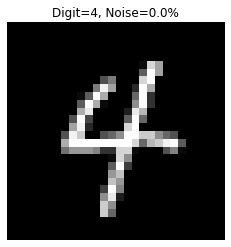

Epoch 1, Loss: 0.10920298099517822, Accuracy: 79.56458282470703
 -- 
Epoch 2, Loss: 0.06985339522361755, Accuracy: 80.19477081298828
 -- 
Epoch 3, Loss: 0.057543568313121796, Accuracy: 79.85428619384766
 -- 
Epoch 4, Loss: 0.0408923365175724, Accuracy: 79.74137878417969
 -- 
Epoch 5, Loss: 0.029925623908638954, Accuracy: 80.39830017089844
 -- 
Epoch 6, Loss: 0.02507132664322853, Accuracy: 80.6454086303711
 -- 
Epoch 7, Loss: 0.022787507623434067, Accuracy: 80.75659942626953
 -- 
Epoch 8, Loss: 0.02135458216071129, Accuracy: 80.82882690429688
 -- 
Epoch 9, Loss: 0.020249448716640472, Accuracy: 80.88214111328125
 -- 
Epoch 10, Loss: 0.019458089023828506, Accuracy: 80.9204330444336
 -- 
Epoch 11, Loss: 0.01879369281232357, Accuracy: 80.95463562011719
 -- 
Epoch 12, Loss: 0.018252993002533913, Accuracy: 80.97989654541016
 -- 
Epoch 13, Loss: 0.017774153500795364, Accuracy: 81.0042495727539
 -- 
Epoch 14, Loss: 0.01735217683017254, Accuracy: 81.02483367919922
 -- 
Epoch 15, Loss: 0.01707096

In [0]:
# Elements for the neural network
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')
model = AutoEncoder()
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

train_dataset, test_dataset = load_and_prep_data(NOISE_RATIO)
if VISUALIZE_IMAGE_EXAMPLE:
    visualize_image_example(train_dataset, NOISE_RATIO)
train_model(train_dataset)
if VISUALIZE_LATENT_SPACE:
    visualize_latent_space(test_dataset, 'Latent Space with {}% noise'.format(NOISE_RATIO * 100))
if SHOW_PREDICTION_EXAMPLE:
    visualize_image_example(test_dataset, NOISE_RATIO) 